## Imports

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.models import Model
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import boto3
import csv

## Classes to handle dataset images

In [10]:
class DatasetHandler:
    def __init__(self,
                 model_path,
                 dataset,
                 img_width=600,
                 img_height=200,
                 batch_size=32,
                 thresh_csv_fname=None,
                 metrics_csv_fname=None):
        
        self.model_path = model_path
        self.dataset = dataset
        self.obstacle_dataset = os.path.join(dataset, 'obstacle')
        self.no_obstacle_dataset = os.path.join(dataset, 'no_obstacle')
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self.sdv_images = []
        self._update_image_lists = False
        self.batch_size = batch_size
            
        # Will be determined while reading all images from dataset
        self.num_obstacles = 0
        self.num_no_obstacles = 0
        self.num_sdvs = 0
        self.num_images = 0
            
        (self.obstacle_image_names,
        self.num_obstacles) = self._get_all_dataset_image_names(self.dataset, 'obstacle')
        (self.no_obstacle_image_names,
        self.num_no_obstacles) = self._get_all_dataset_image_names(self.dataset, 'no_obstacle')
        self.datagen, self.steps = self.get_datagen()
        
        self.model_score = ModelScore()

        if thresh_csv_fname:
            thresh_csv_path = os.path.join(model_path, thresh_csv_fname)
            self.f_thresh_csv = open(thresh_csv_path, 'w')
            self.thresh_csv_writer = csv.writer(self.f_thresh_csv)
            
            self.thresh_csv_header = ['model',
                                      'dataset',
                                      'Max Lost Ratio',
                                      'Lower Threshold',
                                      'Upper Threshold',
                                      'Total Predictions',
                                      'TP',
                                      '% TP',
                                      'TN',
                                      '% TN',
                                      'FP',
                                      '% FP',
                                      'FN',
                                      '% FN',
                                      'Not Decided',
                                      '% Not Decided',
                                      'True Not Decided',
                                      '% True Not Decided']
            
            self.thresh_csv_writer.writerow(self.thresh_csv_header)
            
        if metrics_csv_fname:
            metrics_csv_path = os.path.join(model_path, metrics_csv_fname)
            self.f_metrics_csv = open(metrics_csv_path, 'w')
            self.metrics_csv_writer = csv.writer(self.f_metrics_csv)

            metrics_prefixes = ['test', 'validation', '']
            metrics_separators = [' ', ' ', '']
            metrics_functions = ['auc', 'recall', 'specifity']
            
            self.metrics_csv_header = ['Trial Name']
            self.metrics_csv_header.append('Model Score')
            self.metrics_csv_header.append('Lost True Values %')
            self.metrics_csv_header.append('Lower Threshold')
            self.metrics_csv_header.append('Upper Threshold')
            self.metrics_csv_header.append('% FP')
            self.metrics_csv_header.append('% FN')
            
            for i, metrics_prefix in enumerate(metrics_prefixes):
                for metrics_function in metrics_functions:
                    metric_name = metrics_separators[i].join([metrics_prefix, metrics_function])
                    self.metrics_csv_header.append('max ' + metric_name)
            
            self.metrics_csv_writer.writerow(self.metrics_csv_header)        
                            
    def _get_all_dataset_image_names(self, dataset, class_name):
        class_dataset = os.path.join(dataset, class_name)
        image_names = os.listdir(class_dataset)
        image_paths = [os.path.join(class_dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_datagen(self):
        datagen = ImageDataGenerator(rescale=1./255)
        it = DirectoryIterator(self.dataset, image_data_generator=datagen)
        steps= it.__len__()
        
        return datagen, steps

    # Special generator to generate the 3 parts of the input image as 3 separate input images
    def three_im_generator(self, gen, dataset, target_size, batch_size, class_mode):

        im_gen = gen.flow_from_directory(dataset, 
                                         target_size=target_size, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         class_mode=class_mode)
        self.filenames = im_gen.filenames

        while True:
            im1_s, im2_s, im3_s = [], [], []
            images, labels = im_gen.next()

            for im in images:
                w = im.shape[1]
                im1 = im[:, :w//3]
                im2 = im[:, w//3:(w*2)//3] 
                im3 = im[:, (w*2)//3:] 
                im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
                im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
                im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
                im1_s.append(im1)
                im2_s.append(im2)
                im3_s.append(im3)

            im1_s = np.array(im1_s)
            im2_s = np.array(im2_s)
            im3_s = np.array(im3_s)
            yield [im1_s, im2_s, im3_s], labels
            
    def get_metrics(self, model, color_mode='rgb'):
        eval_generator = self.three_im_generator(
            self.datagen,
            self.dataset,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        return model.evaluate(eval_generator, steps=self.steps, verbose=1)
        
    def get_predictions(self, model, color_mode='rgb'):
        predict_generator = self.three_im_generator(
            self.datagen,
            self.dataset,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary'
        )
        
        return model.predict(predict_generator, steps=self.steps, verbose=1)
        
    def print_model_metrics(self, model, color_mode):
        metrics = self.get_metrics(model, color_mode)

        for name, value in zip(model.metrics_names, metrics):
            print(name, ': ', value)
            
    # Compute and plot multi-class confusion-matrix
    def plot_cm(self, model_path, labels, predictions, threshold):
        cm = confusion_matrix(labels, predictions > threshold) 
        print(f'cm: {cm}')
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label') 
        
    # Compute and plot multi-class confusion-matrix, with given threshold values
    def plot_cm_with_thresh(self,
                            model_path,
                            labels,
                            predictions,
                            predicted_classes,
                            lower_thresh,
                            upper_thresh):
        
        # Calculate number of values for each <class vs. class> considering the thresholds
        
        noobs_as_noobs = len([p for p in predicted_classes[:self.num_no_obstacles] if p==0])        
        noobs_as_obs = len([p for p in predicted_classes[:self.num_no_obstacles] if p==1])
        obs_as_noobs = len([p for p in predicted_classes[self.num_no_obstacles:] if p==0])
        obs_as_obs = len([p for p in predicted_classes[self.num_no_obstacles:] if p==1])
        noobs_as_undecided = len([p for p in predicted_classes[:self.num_no_obstacles] if p==2])        
        obs_as_undecided = len([p for p in predicted_classes[self.num_no_obstacles:] if p==2])
        
        cm = [[noobs_as_noobs, noobs_as_obs, noobs_as_undecided],
             [obs_as_noobs, obs_as_obs, obs_as_undecided]]
        
        print(f'cm: {cm}')
        
        # Creating a dataframe for a array-formatted Confusion matrix
        cm_df = pd.DataFrame(cm,
                             index = ['NO_OBSTACLE', 'OBSTACLE'], 
                             columns = ['NO_OBSTACLE', 'OBSTACLE', 'NOT_DECIDED'])
        
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')        
        
    # Compute and plot confusion-matrix (TP, FP, TN, FN)
    def calc_cm(self,
                model_path,
                labels,
                predictions,
                p=0.5,
                max_lost_ratio=0,
                not_decided=0,
                trues=0,
                true_not_decided=0,
                lower_threshold=None,
                upper_threshold=None,
                print_params=True,
                print_to_csv=False):

        cm = confusion_matrix(labels, predictions > p)        

        predicts = sum(sum(x) for x in cm)
        tot_predicts = predicts + not_decided
        
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
        
        TN_percent = (TN/tot_predicts)*100
        FP_percent = (FP/tot_predicts)*100
        FN_percent = (FN/tot_predicts)*100
        TP_percent = (TP/tot_predicts)*100
        not_decided_percent = (not_decided/tot_predicts)*100
        true_not_decided_percent = (true_not_decided/trues)*100

        if print_params:
            print()
            if max_lost_ratio:
                print(f'Max Lost Ratio: {max_lost_ratio}')
            print(f'No Obstacles Detected (True Negatives): {TN} ({TN_percent:.2f}%)')
            print(f'No Obstacles Incorrectly Detected (False Positives): {FP} ({FP_percent:.2f}%)')
            print(f'Obstacles Missed (False Negatives): {FN} ({FN_percent:.2f}%)')
            print(f'Obstacles Detected (True Positives): {TP} ({TP_percent:.2f}%)')
            if not_decided:
                print(f'Not Decided: {not_decided} ({not_decided_percent:.2f}%)')
            if true_not_decided:
                print(f'True Not Decided: {true_not_decided} ({true_not_decided_percent:.2f}%)')
            print(f'Total Obstacles: {tot_predicts}')
        
        self.model_score.add_model_option(true_not_decided,
                                          true_not_decided_percent/100.0,
                                          FP,
                                          FP_percent/100.0,
                                          FN,
                                          FN_percent/100.0,
                                          lower_threshold,
                                          upper_threshold,
                                          predictions=predictions)
        
        if print_to_csv:
            # Prepare arguments for writing to csv
            args = {'model': model_path,
                    'Max Lost Ratio': max_lost_ratio,
                    'Lower Threshold': lower_threshold,
                    'Upper Threshold': upper_threshold,
                    'Total Predictions': tot_predicts,
                    'TP': TP,
                    '% TP': TP_percent,
                    'TN': TN,
                    '% TN': TN_percent,
                    'FP': FP,
                    '% FP': FP_percent,
                    'FN': FN,
                    '% FN': FN_percent,
                    'Not Decided': not_decided,
                    '% Not Decided': not_decided_percent,
                    'True Not Decided': true_not_decided,
                    '% True Not Decided': true_not_decided_percent}
            self.write_csv(**args)
        
        
    # Same as above, with consideration of lower and upper threshold 
    # For values between those thresholds "not decided" is returned, 
    # so it lowers the no. of FP and FN
    def calc_cm_considering_thresholds(self,
                                       model_path,
                                       labels,
                                       predictions,
                                       lower_threshold,
                                       upper_threshold,
                                       max_lost_ratio=0,
                                       threshold=0.5,
                                       print_params=True,
                                       print_to_csv=False):
        no_obs_preds = predictions[:self.num_no_obstacles]
        no_obs_margin_preds = [p for p in no_obs_preds if p < lower_threshold or p > upper_threshold]
        no_obs_margin_labels = [0]*len(no_obs_margin_preds)
        true_no_obs_preds = [p for p in no_obs_preds if p <= 0.5]
        true_no_obs_not_decided_preds = [p for p in no_obs_preds if lower_threshold < p <= 0.5]
        obs_preds = predictions[self.num_no_obstacles:]
        obs_margin_preds = [p for p in obs_preds if p < lower_threshold or p > upper_threshold]
        obs_margin_labels = [1]*len(obs_margin_preds)
        true_obs_preds = [p for p in obs_preds if p >= 0.5]
        true_obs_not_decided_preds = [p for p in obs_preds if upper_threshold > p >= 0.5]
        margin_preds = no_obs_margin_preds + obs_margin_preds
        margin_preds = np.array(margin_preds, dtype=float)
        true_preds = true_no_obs_preds + true_obs_preds
        true_not_decided_preds = true_no_obs_not_decided_preds + true_obs_not_decided_preds
        margin_labels = no_obs_margin_labels + obs_margin_labels
        margin_labels = np.array(margin_labels, dtype=float)
        not_decided = len(predictions) - len(margin_preds)
        trues = len(true_preds)
        true_not_decided = len(true_not_decided_preds)

        self.calc_cm(model_path,
                     margin_labels,
                     margin_preds,
                     max_lost_ratio=max_lost_ratio,
                     not_decided=not_decided,
                     trues=trues,
                     true_not_decided=true_not_decided,
                     lower_threshold=lower_threshold,
                     upper_threshold=upper_threshold,
                     print_params=print_params,
                     print_to_csv=print_to_csv)
            
    def display_false_negatives(self, predictions, lower_threshold):
        image_names = [s.split('/')[-1] for s in self.obstacle_image_names]
        false_negatives = [fname for i, fname in enumerate(self.filenames)\
                           if fname.split('/')[-1] in image_names\
                           and predictions[i] < lower_threshold]
        preds = [p for i, p in enumerate(predictions)\
                 if self.filenames[i].split('/')[-1] in image_names\
                 and p < threshold]

        if 500 > len(false_negatives) > 1:
            num_images = len(false_negatives)
            _, axarr = plt.subplots(num_images, 1, figsize=(num_images, num_images))

            for i, fname in enumerate(false_negatives):
                imname = fname.split('/')[-1]
                impath = os.path.join(self.obstacle_dataset, imname)
                im = cv2.imread(impath)
                axarr[i].imshow(im)
                axarr[i].set_title(str(preds[i]) + ' ' + imname + (' '*30))
            plt.show()
        elif false_negatives:
            fname = false_positives[0]
            imname = fname.split('/')[-1]
            impath = os.path.join(self.obstacle_dataset, imname)
            im = cv2.imread(impath)
            plt.imshow(im)
            plt.title(str(preds[0]) + ' ' + imname)
            plt.show() 
            
    def display_false_positives(self, predictions, upper_threshold):
        image_names = [s.split('/')[-1] for s in self.no_obstacle_image_names]
        false_positives = [fname for i, fname in enumerate(self.filenames)\
                           if fname.split('/')[-1] in image_names\
                           and predictions[i] > upper_threshold]
        preds = [p for i, p in enumerate(predictions)\
                 if self.filenames[i].split('/')[-1] in image_names\
                 and p > upper_threshold]

        if 500 > len(false_positives) > 1:
            num_images = len(false_positives)
            _, axarr = plt.subplots(num_images, 1, figsize=(num_images, num_images))

            for i, fname in enumerate(false_positives):
                imname = fname.split('/')[-1]
                impath = os.path.join(self.no_obstacle_dataset, imname)
                im = cv2.imread(impath)
                print(f'FP prediction: {preds[i]}, imname: {imname}')
                axarr[i].imshow(im)
                axarr[i].set_title(str(preds[i]) + ' ' + imname + (' '*30))
            plt.show()
        elif false_positives:
            fname = false_positives[0]
            imname = fname.split('/')[-1]
            impath = os.path.join(self.no_obstacle_dataset, imname)
            im = cv2.imread(impath)
            plt.imshow(im)
            plt.title(str(preds[0]) + ' ' + imname)
            plt.show()
            
    def display_not_decided(self, predcitions, filenames, lower_threshold, upper_threshold):
        obstacle_image_names = [s.split('/')[-1] for s in self.obstacle_image_names]
        no_obstacle_image_names = [s.split('/')[-1] for s in self.no_obstacle_image_names]
        obs_title = ''
        
        not_decided = [fname for i, fname in enumerate(filenames)\
                       if ((lower_threshold < predictions[i] <= 0.5)\
                           and (fname.split('/')[-1] in no_obstacle_image_names))\
                           or ((0.5 <= predictions[i] < upper_threshold)\
                           and (fname.split('/')[-1] in obstacle_image_names))]
        
        preds = [p for i, p in enumerate(predictions)\
                       if ((lower_threshold < p <= 0.5)\
                           and (filenames[i].split('/')[-1] in no_obstacle_image_names))\
                           or ((0.5 <= p < upper_threshold)\
                           and (filenames[i].split('/')[-1] in obstacle_image_names))]

        if 500 > len(not_decided) > 1:
            num_images = len(not_decided)
            _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

            for i, fname in enumerate(not_decided):
                imname = fname.split('/')[-1]
                if imname in obstacle_image_names:
                    impath = os.path.join(self.obstacle_dataset, imname)
                    obs_title = 'obs'
                else:
                    impath = os.path.join(self.no_obstacle_dataset, imname)
                    obs_title = 'no_obs'
                im = cv2.imread(impath)
                axarr[i].imshow(im)
                axarr[i].set_title(' '.join([imname, obs_title, str(preds[i]), (' '*30)]))
            plt.show()
        elif not_decided:
            imname = not_decided[0].split('/')[-1]
            if imname in obstacle_image_names:
                impath = os.path.join(self.obstacle_dataset, imname)
                obs_title = 'obs'
            else:
                impath = os.path.join(self.no_obstacle_dataset, imname)
                obs_title = 'no_obs'
            im = cv2.imread(impath)
            plt.imshow(im)
            plt.title(' '.join([imname, obs_title, str(preds[0])]))
            plt.show()

    # An algorithm for optimal threshold taken from 
    # https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    # left here on case we consider re-using it.
    # Currently we are using the 2nd algorithm below
    def optimal_threshold_by_gmeans(self, num_no_obstacles, num_obstacles, predictions):
        true_values = [0]*num_no_obstacles + [1]*num_obstacles 
        fpr, tpr, thresholds = roc_curve(true_values, predictions)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)

        return thresholds[ix]    
 
    # 2nd algorithm for finding optimal threshold, own developed
    # Currently used
    # Params: 
    #    -- predictions - a list of predicted values for no_obstacle / obstacle
    #    -- max_lost_ratio - a float [0.0-1.0], indicating the target maximum ratio (%/100)
    #    of ("not decided" / all) true values, for TP and TN - this is to avoid putting extreme 
    #    low/high thresholds, which will lower FN/FP, but will leave too few True values returned.
    #    This ratio ("not_decided" / all) is called here "lost ratio"
    # Steps:
    # 1. Set as (min_thresold / max_thresold) ==> (min(FN) / max(FP))
    #       Using this will perform with 0 FN/FP, 
    #       as there are neither FN below lower_thresold, not FP above upper_threshold,
    #       but --potentially-- with too many "not decided"
    # 2. If the lost ratio is too high - start lowering it to the target, using binary search
    #       to find the point where the ratio does not exceed the maximum lost-ratio,
    #       while keeping the lower/upper thresholds as close as possible to their 
    #       original values. 
    def find_thresholds(self, predictions, max_lost_ratio=0.1, single_threshold=0.5):
        no_obs_preds = predictions[:handler.num_no_obstacles]
        obs_preds = predictions[handler.num_no_obstacles:]
        false_positives = np.array([p for p in no_obs_preds if p >= single_threshold])
        false_negatives = np.array([p for p in obs_preds if p < single_threshold])
        true_positives = np.array([p for p in obs_preds if p >= single_threshold])
        true_negatives = np.array([p for p in no_obs_preds if p < single_threshold])
        
        if false_positives.size == 0:
            print(f'*** No False Positives. Need to use a single_threshold lower than {single_threshold}.')
            return None, None
        
        if false_negatives.size == 0:
            print(f'*** No False Negatives. Need to use a single_threshold higher than {single_threshold}.')
            return None, None
        
        false_positives.sort(axis=0) 
        false_negatives.sort(axis=0)
        true_positives.sort(axis=0)
        true_negatives.sort(axis=0)

        true_positives_above = np.array([p for p in true_positives if p > max(false_positives)])
        true_negatives_below = np.array([p for p in true_negatives if p < min(false_negatives)])
        lost_true_positives = np.array([p for p in true_positives if p <= max(false_positives)])
        true_positives_lost_ratio = len(lost_true_positives) / len(true_positives)
        lost_true_negatives = np.array([p for p in true_negatives if p >= min(false_negatives)])
        true_negatives_lost_ratio = len(lost_true_negatives) / len(true_negatives)

        lower_threshold = min(false_negatives)
        lower_threshold_ind = np.where(true_negatives > lower_threshold)[0][0]
        num_true_negatives = len(true_negatives)
        gap = num_true_negatives - lower_threshold_ind
        
        # Binary search to find the point where no. of "not decided" satisfies the target

        if true_negatives_lost_ratio > max_lost_ratio:
            while gap:
                lost_ratio_diff = true_negatives_lost_ratio - max_lost_ratio
                if abs(lost_ratio_diff) < 0.01:
                    break
                gap //= 2
                if lost_ratio_diff < 0.0:
                    lower_threshold_ind -= gap
                else:
                    lower_threshold_ind += gap
                lost_true_negatives = true_negatives[lower_threshold_ind:]
                true_negatives_lost_ratio = len(lost_true_negatives) / num_true_negatives

            lower_threshold = true_negatives[lower_threshold_ind] 
            
        upper_threshold = max(false_positives)
        upper_threshold_ind = np.where(true_positives > upper_threshold)[0][0]
        num_true_positives = len(true_positives)
        gap = upper_threshold_ind

        # Binary search to find the point where no. of "not decided" satisfies the target
        
        if true_positives_lost_ratio > max_lost_ratio:
            while gap:
                lost_ratio_diff = true_positives_lost_ratio - max_lost_ratio
                if abs(lost_ratio_diff) < 0.01:
                    break
                gap //= 2
                if lost_ratio_diff < 0.0:
                    upper_threshold_ind += gap
                else:
                    upper_threshold_ind -= gap
                lost_true_positives = true_positives[:upper_threshold_ind]
                true_positives_lost_ratio = len(lost_true_positives) / num_true_positives

            upper_threshold = true_positives[upper_threshold_ind]
            
        return lower_threshold[0], upper_threshold[0]
    
    def write_metrics_to_csv(self, trial_component_display_name, print_params=True):
        client = boto3.client('sagemaker', region_name='eu-west-1')
        trials = client.list_trial_components()['TrialComponentSummaries']
        trial = [t for t in trials if t['DisplayName'] == trial_component_display_name]
        trial_description = None
        
        if trial:
            trial_component_name = trial[0]['TrialComponentName']
            trial_description = client.describe_trial_component(TrialComponentName=trial_component_name)

        metrics_values = [trial_component_display_name]        

        best_option = self.model_score.scored_models[self.model_score.best_option]
        metrics_values.append(best_option['score'])
        metrics_values.append(best_option['lost_true_values_percentage'])
        metrics_values.append(best_option['lower_threshold'])
        metrics_values.append(best_option['upper_threshold'])
        metrics_values.append(best_option['false_positives_percentage'])
        metrics_values.append(best_option['false_negatives_percentage'])
        
        if print_params:
            print(f'best option: {best_option["lost_true_values_percentage"]:.2f}')
            print(f'score: {best_option["score"]}')
            print(f'lower_threshold: {best_option["lower_threshold"]:.2f}')
            print(f'upper_threshold: {best_option["upper_threshold"]:.2f}')
            print(f'%FP: {best_option["false_positives_percentage"]*100:.2f}')
            print(f'%FN: {best_option["false_negatives_percentage"]*100:.2f}')

        if trial_description:
            metrics = trial_description['Metrics']

            metrics_prefixes = ['test', 'validation', '']
            metrics_separators = [' ', ' ', '']
            metrics_functions = ['auc', 'recall', 'specifity']        

            for i, metrics_prefix in enumerate(metrics_prefixes):
                for metrics_function in metrics_functions:
                    metric_name = metrics_separators[i].join([metrics_prefix, metrics_function])
                    metric_value = [m for m in metrics if m['MetricName'] == metric_name]
                    metrics_values.append(metric_value[0]['Max'])
                                
        self.metrics_csv_writer.writerow(metrics_values) 

    def write_csv(self, **args):        
        row = []
        keys = args.keys()
        
        if 'model' in keys:
            row.append(args['model'])
            
        row.append(self.dataset)
        
        for col in self.thresh_csv_header[2:]:
            if col in keys:
                row.append(args[col])
            else:
                row.append(None)
        
        self.thresh_csv_writer.writerow(row)
        
    # Method to run when class is deleted
    def __del__(self):
        self.f_thresh_csv.close()
        self.f_metrics_csv.close()            

## Class to calculate model's score

In [11]:
class ModelScore():
    def __init__(self, alpha=0.7, beta=1.2, gamma=30):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.max_score = 0.0
        self.scored_model_ind = 0
        self.scored_models = []
        
    '''
    Cliff shape function
    
    Based on the Sigmoid function:
        1/(1 + np.exp(-x))

    with:
    1. Changing (x) to (1-x), so we flip the curve to be high near 0 and decline sharply at some point, till reaching zero
    2. Adding alpha, beta and gamma modifiers to enable controlling the curve's attributes:
        * alpha controls the point where the graph starts to decline sharply (= the % of lost true values which is berable and should get relatively high score for this aspect)
        * beta controls the width of the sharply declining portion of the curve
        * gamma controls the smoothness of the cliff-shape part of the graph. A high gamma will make the curvie less somooth, i.e. more 'cliffy'. 

    So our Sigmoid-modofied function is:

        1/(1 + np.exp(-(1-(x+alpha)*beta)*gamma)) 
    '''
    def cliff(self, x):
        return 1/(1 + np.exp(-(1-(x+self.alpha)*self.beta)*self.gamma)) 
    
    # A method to insert into overall model's scores an option, regarding 
    # the lost_true_value_percentage. 
    # The goal is that the class remembers the score attached to this option,
    # then can compare all scores and find the best one
    def add_model_option(self,
                         lost_true_values,
                         lost_true_values_percentage,
                         false_positives,
                         false_positives_percentage,
                         false_negatives,
                         false_negatives_percentage,
                         lower_threshold,
                         upper_threshold,
                         predictions):
        
        s1 = self.cliff(lost_true_values_percentage)
        s2 = 1.0 - (false_positives_percentage + false_negatives_percentage)
        score = (s1 + s2) / 2
        if score > self.max_score:
            self.max_score = score
            self.best_option = self.scored_model_ind
        scored_model = {}
        scored_model['score'] = score
        scored_model['lost_true_values'] = lost_true_values
        scored_model['lost_true_values_percentage'] = lost_true_values_percentage
        scored_model['false_positives'] = false_positives
        scored_model['false_positives_percentage'] = false_positives_percentage
        scored_model['false_negatives'] = false_negatives
        scored_model['false_negatives_percentage'] = false_negatives_percentage
        scored_model['lower_threshold'] = lower_threshold
        scored_model['upper_threshold'] = upper_threshold
        scored_model['predictions'] = predictions
        self.scored_models.append(scored_model)
        self.scored_model_ind += 1

## Main

Found 1527 images belonging to 2 classes.
Found 1527 images belonging to 2 classes.
48/48 [==============================] - 33s 670ms/step
Experimenting best max_ratio ...
0.0050...0.0100...0.0150...0.0200...0.0250...0.0300...0.0350...0.0400...0.0450...0.0500...0.0550...0.0600...0.0650...0.0700...0.0750...0.0800...0.0850...0.0900...0.0950...0.1000...0.1050...0.1100...0.1150...0.1200...0.1250...0.1300...0.1350...0.1400...0.1450...0.1500...0.1550...0.1600...0.1650...0.1700...0.1750...0.1800...0.1850...0.1900...0.1950...0.2000...


best option score: 0.9886403947612706
best option lower threshold: 0.24854403734207153
best option upper threshold: 0.6922571659088135
best option lost true values: 17 (1.14%)
best option false negatives: 11 (0.72%)
best option false positives: 5 (0.33%)
cm: [[735, 5, 16], [11, 743, 17]]
cm: [[735, 5, 16], [11, 743, 17]]



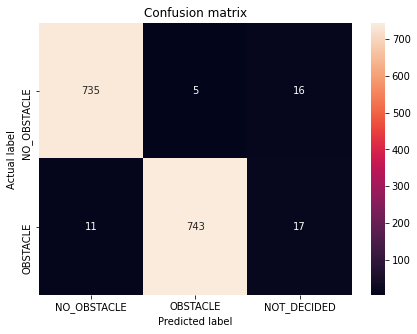

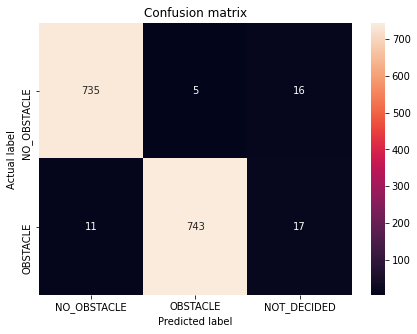

In [12]:
# -- Variables --
trial_component_display_name = None
model_path = '/home/drevital/cs_video_processor/models/feb23_c_std_15_gamma_15'
dataset = '/home/drevital/obstacles_classification_datasets/feb23_c_std_15_gamma_15/eval'
model_name = model_path.split('/')[-1]
color_mode = 'rgb'
thresh_csv_fname = f'model_thresholds.{model_name}.csv'
#metrics_csv_fname = f'model_metrics.{model_name}.csv'
#thresh_csv_fname = None
print_metrics = False
metrics_csv_fname = None
print_cm_params=False
display_cm_figure = False
display_false_negatives = False
display_false_positives = False
display_not_decided = False
print_best_option_params=True

# -- Run the Evaluation --
model = tf.keras.models.load_model(model_path)
handler = DatasetHandler(model_path, 
                         dataset, 
                         thresh_csv_fname=thresh_csv_fname,
                         metrics_csv_fname=metrics_csv_fname)

# -- Print metrics
if print_metrics:
    metrics = handler.print_model_metrics(model, color_mode)
    
# Build labels array for prediction
labels = np.array([0]*handler.num_no_obstacles\
                + [1]*handler.num_obstacles)

# -- Predict with the model
predictions = handler.get_predictions(model, color_mode=color_mode)

# Find optimal lower, upper thresholds per given max limit of "not decided" ("lost") predictions
max_lost_ratios = np.arange(start=0.005, stop=0.205, step=0.005)

print('Experimenting best max_ratio ...')
for max_lost_ratio in max_lost_ratios:
    ret = handler.find_thresholds(predictions,
                                  max_lost_ratio=max_lost_ratio,
                                  single_threshold=0.50)
    lower_threshold, upper_threshold = ret
    if not lower_threshold or not upper_threshold:
        break
    
    print(f'{max_lost_ratio:.4f}', end='...')
    # Print confusion-matrix after using recommended thresholds
    handler.calc_cm_considering_thresholds(model_path,
                                           labels,
                                           predictions,
                                           lower_threshold,
                                           upper_threshold,
                                           max_lost_ratio=max_lost_ratio,
                                           threshold=0.5,
                                           print_params=print_cm_params,
                                           print_to_csv=False)
    
if handler.model_score.scored_models:    
    best_option = handler.model_score.scored_models[handler.model_score.best_option]

    print('\n\n')
    print(f'best option score: {best_option["score"]}')
    print(f'best option lower threshold: {best_option["lower_threshold"]}')
    print(f'best option upper threshold: {best_option["upper_threshold"]}')
    print(f'best option lost true values: {best_option["lost_true_values"]}', end = ' ')
    print(f'({best_option["lost_true_values_percentage"]*100:.2f}%)')
    print(f'best option false negatives: {best_option["false_negatives"]}', end=' ')
    print(f'({best_option["false_negatives_percentage"]*100:.2f}%)')
    print(f'best option false positives: {best_option["false_positives"]}', end=' ')
    print(f'({best_option["false_positives_percentage"]*100:.2f}%)')

    lower_threshold = best_option['lower_threshold']
    upper_threshold = best_option['upper_threshold']

    # -- Generate predictions array in the for [0,1,2] for [no_obstacle, obstacle, not_decided]
    predicted_classes= []
    for prediction in predictions:
        classification_states = [prediction <= lower_threshold,
                                 prediction >= upper_threshold,
                                 lower_threshold < prediction < upper_threshold]
        predicted_classes.append(np.where(classification_states)[0][0])

    # -- Print confusion-matrix considering the older "no decision" thresholds
    handler.plot_cm_with_thresh(model_path,
                                labels,
                                predictions,
                                predicted_classes,
                                lower_threshold,
                                upper_threshold)

    handler.plot_cm_with_thresh(model_path,
                                labels,
                                predictions,
                                predicted_classes,
                                0.10,
                                0.51)
    if display_false_negatives:
        print('\nFALSE NEGATIVES\n')
        handler.display_false_negatives(predictions, filenames, lower_threshold)

    if display_false_positives:
        print('\nFALSE POSITIVES\n')
        handler.display_false_positives(predictions, filenames, upper_threshold)

    if display_not_decided:
        print('\nNOT DECIDED\n')
        handler.display_not_decided(predictions, filenames, lower_threshold, upper_threshold)

    print()

    # Retrieve model's metrics from SageMaker and write them to the handler's .csv file
    if trial_component_display_name:
        handler.write_metrics_to_csv(trial_component_display_name,
                                 print_params=print_best_option_params)
del handler